In [1]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input,Flatten,Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import img_to_array

2024-09-23 10:39:14.758546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
class Drones:

    def __init__(self, path) -> None:
        self.path = path
        self.files = self.get_image_filenames()
        self.labels = self.get_labels()

        self.train_images = []
        self.test_images = []
        self.train_targets = []
        self.test_targets = []
        self.train_filenames = []
        self.test_filenames = []
        
        # The arrays below are filled in via the get_images() method
        self.imagesizes = []
        self.imagedata = []
        self.images = self.get_images()

        # Make sure all arrays are the same length
        assert(len(self.files) == len(self.labels))
        assert(len(self.files) == len(self.images))
        assert(len(self.images) == len(self.imagesizes))

    def get_image_filenames(self):
        print('INFO: Loading filenames...')
        files = []
        for file in os.listdir(self.path + "image/"):
            if file.endswith(".jpg"):
                files.append(file)
        return files
    
    def get_labels(self):
        print('INFO: Loading labels...')
        labels = []
        for file in self.files:
            file = file.replace(".jpg", ".txt")
            if file.endswith(".txt"):
                with open(self.path + "label/" + file) as f:
                    line = f.read()
                    try:
                        assert len(line.split(' ')) == 5
                    except AssertionError: 
                        print(file, "has a format error")
                        raise
                    [class_id, x, y, w, h] = line.split(' ')
                    intline = [int(float(x)), int(float(y)), int(float(w)), int(float(h))]
                    labels.append(intline)
            else:
                print(f'FAIL: label file {file} detected without txt extension')
        return labels
    
    def get_images(self):
        print('INFO: Loading images...')  
        images = []
        for file in self.files:
            img = cv2.imread(self.path + "image/" + file)
            images.append(img)
            self.imagesizes.append(img.shape)

            image = load_img(self.path + "image/" + file,target_size=(224,224))
            image = img_to_array(image)
            self.imagedata.append(image)
        return images
    
    def draw_image(self, index: str):
        img = self.images[index]
        cv2.rectangle(
            img,
            (self.labels[index][0], self.labels[index][1]), 
            (self.labels[index][0] + self.labels[index][2], self.labels[index][1] + self.labels[index][3]),
            (0,255,0),
            3
        )
        plt.imshow(img)

    def normalize(self):
        self.imagedata = np.array(self.imagedata, dtype='float32') / 255.0
        self.labels = np.array(object=self.labels, dtype='float32') / 224
        print('Ok: data has been normalised')

    def split_data(self):
        # Split the dataset
        split = train_test_split(self.imagedata, self.labels, self.files, test_size=0.25, random_state=42)
        (self.train_images, self.test_images) = split[:2]
        (self.train_targets, self.test_targets) = split[2:4]
        (self.train_filenames, self.test_filenames) = split[4:]
        print('Ok: data has been split')


    def build_model(self, epochs:int = 10):
        vgg=tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))
        vgg.summary()

        # Transfer Learning
        vgg.trainable = False
        flatten = vgg.output
        flatten = Flatten()(flatten)
        bboxhead = Dense(256,activation="relu")(flatten) 
        bboxhead = Dense(128,activation="relu")(bboxhead) 
        bboxhead = Dense(64,activation="relu")(bboxhead)
        bboxhead = Dense(32,activation="relu")(bboxhead)
        bboxhead = Dense(4,activation="relu")(bboxhead)
        bboxhead = Dense(4, "softmax")(bboxhead)

        self.model = Model(inputs = vgg.input,outputs = bboxhead)
        self.model.summary()
        opt = Adam(learning_rate=0.001, amsgrad=True) 
        self.model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])
        history = self.model.fit(
            self.train_images, 
            self.train_targets, 
            validation_data=(self.test_images,self.test_targets), 
            batch_size=32, 
            epochs=epochs, 
            verbose=1
        )

        self.model.save('detect_drones_DSC_16.keras')
        

    def predict(self, imagepath:str):
        import imutils

        print(f'INFO: Loading image {imagepath}...')
        image = load_img(imagepath,target_size=(224,224))
        image = img_to_array(image) / 255.0
        image = np.expand_dims(image,axis=0)

        print('INFO: Predicting drone BB...')
        preds=self.model.predict(image)[0]
        (X2,Y2,W2,H2)=preds*224

        print(f'INFO: Drawing predicted BB: {X2,Y2,W2,H2}')
        image=cv2.imread(imagepath)
        image=imutils.resize(image,width=224)
        (h,w)=image.shape[:2]
        X=int(X2/224*w)
        Y=int(Y2/224*h)
        W=int(W2/224*w)
        H=int(H2/224*h)

        cv2.rectangle(image,(X,Y),(X+W, Y+H),(0,255,0),2)

        plt.imshow(image)
        #cv2.waitKey(0)

    def model_load(self):
        self.model = load_model("detect_drones_DSC_16.keras")


INFO: Loading filenames...
INFO: Loading labels...
INFO: Loading images...
bangkok-thailand-aug-13-2017-260nw-696179545.jpg [205, 41, 167, 79] (280, 390, 3)
Ok: data has been normalised
Ok: data has been split


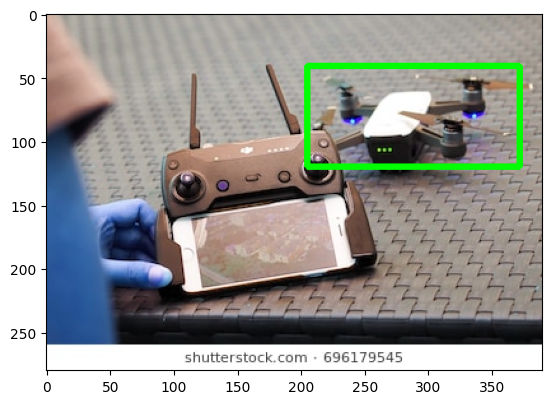

In [15]:
drones = Drones(path="/Users/bcg213/src/datascience/dssl24/UAV/")
index = 64
print(drones.files[index], drones.labels[index], drones.imagesizes[index])
drones.draw_image(index)

drones.normalize()
drones.split_data()

In [16]:
# Training time !
drones.build_model(epochs=5)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           13

 Total params: 21,180,856 (80.80 MB)

 Trainable params: 6,466,168 (24.67 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.4008 - loss: 0.2218 - val_accuracy: 0.8000 - val_loss: 0.1999
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.6883 - loss: 0.2246 - val_accuracy: 0.8000 - val_loss: 0.1992
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7156 - loss: 0.2177 - val_accuracy: 0.8000 - val_loss: 0.1986
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.6931 - loss: 0.2223 - val_accuracy: 0.8000 - val_loss: 0.1980
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.7365 - loss: 0.2379 - val_accuracy: 0.8000 - val_loss: 0.1973


INFO: Loading image /Users/bcg213/src/datascience/dssl24/UAV/predictions/pexels-the-lazy-artist-gallery-1506991-scaled.jpg...
INFO: Predicting drone BB...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
INFO: Drawing predicted BB: (54.682854, 54.350174, 58.718147, 56.248825)


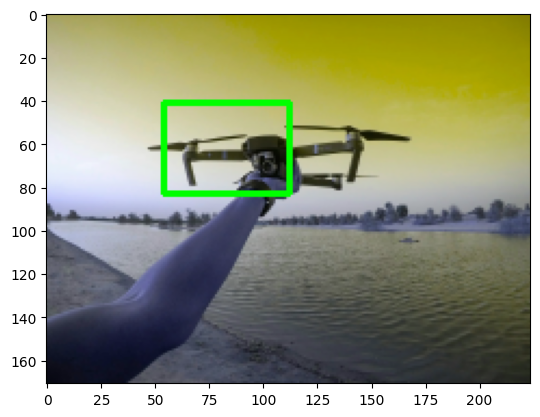

In [27]:
# Let's predict
drones.predict('/Users/bcg213/src/datascience/dssl24/UAV/predictions/pexels-the-lazy-artist-gallery-1506991-scaled.jpg')
#drones.predict('/Users/bcg213/src/datascience/dssl24/UAV/image/03012017-dji-phantom-flying-sky-260nw-554568664.jpg')
 